In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd
import sys
import os
sys.path.append("C:/Users/Jeppe/Documents/GitHub/BiksStonks/Forcasting_Models")
import utils.preprocess as preprocess
import utils.DatasetAccess as DatAccess

In [8]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py


# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
class DatabaseConnection:
    def __init__(self):
        self.conn = self.connect()
    def connect(self):
        try:
            self.conn = pg.connect(
                "dbname='stonksdb' user='postgres' host='localhost' password='admin'")
            print("Connection made succ")
            return self.conn
        except:
            print("I am unable to connect to the database")
            return None
    def close(self):
        self.conn.close()
    
    def GetConnector(self):
        return self.conn
    ### send query to database
    def query(self, query):
        cur = self.conn.cursor()
        cur.execute(query)
        return cur.fetchall()

class DatasetAccess:
    def __init__(self):
        self.conn = DatabaseConnection()
    def getNcompanies(self, N):
        AllCompanies = self.conn.query("SELECT * FROM dataset limit "+ str(N)+"")
        return AllCompanies
    def getStockFromSymbol(self, StockSymbol, column = '*'):
        company = self.conn.query("SELECT * FROM dataset WHERE symbol = '" + StockSymbol + "'")
        self.getStockFromCompany(company, column)
        return company
    def getStockFromCompany(self, companies, column = '*'):
        result = []
        for company in companies:
            result.append(self.conn.query("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "'"))
        return result
    def convertListToString(self, column):
        if type(column) != list:
            return column
        result = ''
        for item in column:
            result += item + ', '
        return result[:-2]
    def getStockDFFromCompany(self, companies, column = '*'):
        result = []
        print(companies)
        for company in companies:
            result.append(pd.read_sql("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "' order by time asc", self.conn.GetConnector()))
        return result
    def GetAllStocksAsDF(self):
        PandaStock = pd.read_sql('SELECT * FROM stock', self.conn.GetConnector())
        print(PandaStock)
    
def GetDF():
    dbaccess = DatasetAccess()
    vestas = pd.read_sql("select * from stock where identifier = 15611 ", dbaccess.conn.GetConnector())
    return vestas

def GetSingleStockDF():
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(2)
    return dbAccess.getStockDFFromCompany(comp, column="close")

def GetStocks(n):
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(n)
    return dbAccess.getStockDFFromCompany(comp, column="close")

def GetStocksHourly(n):
    dbAccess = DatasetAccess()
    comps = dbAccess.getNcompanies(n)
    result = []
    for comp in comps:
        result.append(DatAccess.get_data_for_datasetid(str(comp[0]),dbAccess.conn.GetConnector(),"h")["close"])
    return result
# test = GetStocksHourly(10)

In [9]:
def make_batch():
    replica_input = train
    replica_input = [np.array(replica_input)]
    replica_Input = [n for n in replica_input[0]]
    print("____________-")
    replica_output = target
    replica_output = [np.array(replica_output)]
    replica_Output = [n for n in replica_output[0]]
    print("____________-")
    replica_target = target
    replica_target = [np.array(replica_target)]
    replica_Target = [n for n in replica_target[0]]
    
    #input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]] # takes the number and one hot encodes it
    #print(input_batch)
    #print(replica_Output)
    #output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]] # takes the number and one hot encodes it
    #target_batch = [[word_dict[n] for n in sentences[2].split()]] # takes the number
    # print(input_batch)
    # print([np.array([replica_input])])
    # make tensor
    # return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
    return torch.FloatTensor(replica_Input), torch.FloatTensor(replica_Output), torch.FloatTensor(replica_Target)

In [10]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        #print("dec_inputs1", dec_inputs.shape)
        #dec_inputs1 torch.Size([32, 50, 1]) [batchsize, points, num of vars]
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)
        #print("dec_inputs2", dec_inputs.shape)
        #dec_inputs2 torch.Size([50, 32, 1]) [points, batchsize, num of vars]
        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])
        dec_outputs, hidden = self.dec_cell(dec_inputs, hidden)
        #print("dec_outputs1", dec_outputs.shape)
        #dec_outputs1 torch.Size([50, 32, 128]) [points, batchsize, Hidden]
        enc_outputs = enc_outputs.transpose(0, 1)
        dec_outputs = dec_outputs.transpose(0, 1)
        #print("dec_outputs2", dec_outputs.shape)
        #dec_outputs2 torch.Size([32, 50, 128])[batchsize, points, Hidden]
        enc_outputs = self.attn(enc_outputs)
        
        attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs.transpose(1,2)), dim=-1)
        context = torch.bmm(attention_weights, enc_outputs)
        # print("dec_outputs: ", dec_outputs.shape)
        # print("context: ", context.shape)
        # dec_outputs:  torch.Size([32, 50, 128])
        # context:  torch.Size([32, 50, 128])
        # dec_output : batch_size, n_step, n_hidden
        # context: batch_size, n_step, n_hidden
        # combine: batch_size, n_step, 2 * n_hidden
        combine = torch.cat((dec_outputs, context), 2) #combine:  torch.Size([32, 50, 256])
        #print("combine",combine.shape)
        #combine torch.Size([32, 50, 256])
        # reshape combine from [32, 50, 256] to [32, 10, 256]
        combine = combine.view(combine.shape[0], 10, -1)
        self.pls = nn.Linear(combine.shape[2], n_class)
        #print("combine new",combine.shape)
        #combine new torch.Size([32, 10, 1280])
        #print("output",self.pls(combine).shape)
        #output torch.Size([32, 50, 1])
        
        return self.pls(combine), trained_attn
        # make model shape [n_step, n_class]
        #return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
    
        return score #torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [11]:
from itertools import islice

def window1(seq, n=2):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def getBigData():
    stocks = []
    for stock in GetStocksHourly(10):
        stocks.append(np.array(stock[:5000]).flatten())
    
    WindowedStocks = []
    for stock in stocks:
        WindowedStocks.append(window1(stock, PointSize))

    result = []
    for window in WindowedStocks:
        for i in window:
            result.append(i)

    return result

def getData():
    a = np.array(GetSingleStockDF()[1][:10000]).flatten()
    b = np.array(GetSingleStockDF()[0][:10000]).flatten()

    bop = [a,b]
    result = []
    for i in bop:
        result.append(window1(i,PointSize))
    actual = []
    for it in result:
        for window in it:
            actual.append(window)
    return actual
# bd = getBigData()


In [12]:
if __name__ == '__main__':
    n_step = 90 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell
    n_class = 1
    PointSize = 100
    closingData = np.array(getBigData())
    closingData = (closingData - closingData.mean()) / closingData.std()
    Output_size = 20
    train = [d[:PointSize-Output_size] for d in closingData]
    target = [d[PointSize-Output_size:] for d in closingData]
    dataset_iter = iter(zip(train, target))
    batch_size = 32
    num_layers = 1

    #use pytorch to create the batches
    dtloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(np.array(train)).float(), torch.from_numpy(np.array(target)).float()),
                                           batch_size=batch_size, shuffle=True, drop_last=True)
    #dtloader = torch.dataloader((train,target), batch_size=batch_size, shuffle=True)

    hidden = torch.zeros(num_layers, batch_size, n_hidden)

    model = Attention()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    input_batch, output_batch, target_batch = make_batch()
    output_batch = target_batch
    input_batch = input_batch.unsqueeze(-1)
    output_batch = output_batch.unsqueeze(-1)
    target_batch = target_batch.unsqueeze(-1)    
    # Train
    model.train()
    for epoch in range(50):
        for x, y in dtloader:
            optimizer.zero_grad()
            x = x.unsqueeze(-1)
            y = y.unsqueeze(-1)
            output, _ = model(x, hidden, x)
            #output shape [32,50,1]
            #Wanted output shape [32,10,1]
            #print("Final output shape", output.shape)
            loss = criterion(output, y.squeeze(0))

        if (epoch + 1) % 5 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'MSE =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()
    #2m 30 sec for 2000 points
    #


Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 conne

____________-
____________-


C:\Users\Jeppe\AppData\Local\Temp\ipykernel_11328\3609337783.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  return torch.FloatTensor(replica_Input), torch.FloatTensor(replica_Output), torch.FloatTensor(replica_Target)


Epoch: 0005 MSE = 1.346415
Epoch: 0010 MSE = 0.421721
Epoch: 0015 MSE = 1.415143
Epoch: 0020 MSE = 0.646093
Epoch: 0025 MSE = 0.311261
Epoch: 0030 MSE = 0.207755
Epoch: 0035 MSE = 0.037720
Epoch: 0040 MSE = 0.002207
Epoch: 0045 MSE = 0.021693
Epoch: 0050 MSE = 0.020955


In [13]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([37931, 90, 1]),
 torch.Size([37931, 10, 1]),
 torch.Size([37931, 10, 1]))

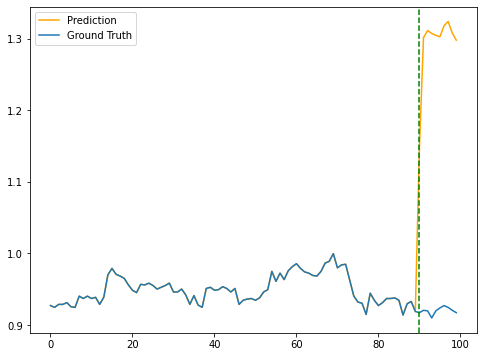

In [25]:
idx = 850

# plot graph
y_ground = np.concatenate((input_batch[idx].reshape(-1), target_batch[idx].reshape(-1)), 0)
model.eval()
hidden = torch.zeros(num_layers, 1, n_hidden)
y_pred = model(input_batch[idx].unsqueeze(0), hidden, input_batch[idx].unsqueeze(0))[0].detach().numpy().reshape(-1) 
y_pred = np.concatenate((input_batch[idx].reshape(-1), y_pred), 0)

# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_pred, label='Prediction', c="orange")
ax.plot(y_ground, label='Ground Truth')
# plt add v line at 50 
ax.axvline(90, color='green', linestyle='--')
ax.legend()
plt.show()

Connection made succ
[(6043, 'Stock', 'DKK', 'A.P. Møller - Mærsk A A/S', 'CSE', '895', 'DK', '6043', 'Instrument', 'MAERSKa:xcse', 'UNKNOWN'), (6041, 'Stock', 'DKK', 'A.P. Møller - Mærsk B A/S', 'CSE', '895', 'DK', '6041', 'Instrument', 'MAERSKb:xcse', 'UNKNOWN')]


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


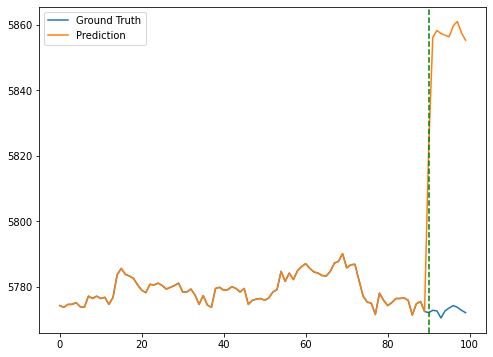

In [15]:
closingData = GetSingleStockDF()[1][:1000].values
# re scale data
y_ground = (y_ground * closingData.std()) + closingData.mean()
y_pred = (y_pred * closingData.std()) + closingData.mean()
# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_ground, label='Ground Truth')
ax.plot(y_pred, label='Prediction')
# plt add v line at 50
ax.axvline(90, color='green', linestyle='--')
ax.legend()
plt.show()

In [16]:
closingData.mean(), closingData.var()


(5571.566, 47794.48764400001)

In [17]:
# use pandas rolling windows to split up the data
data = GetDF()
data.rolling(window=50).mean()
data

Connection made succ


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\AppData\Local\Temp\ipykernel_11328\327577449.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['time'], dtype='object')
  data.rolling(window=50).mean()


,id,identifier,close,high,interest,low,open,time,volume
0,389605,15611,207.4,207.5,0.0,207.4,207.5,2020-10-01 10:05:00,2009.999970
1,389606,15611,207.4,207.5,0.0,207.4,207.5,2020-10-01 10:06:00,1604.999976
2,389607,15611,207.7,207.7,0.0,207.5,207.5,2020-10-01 10:07:00,2529.999962
3,389608,15611,207.6,207.6,0.0,207.6,207.6,2020-10-01 10:08:00,2419.999964
4,389609,15611,207.7,207.7,0.0,207.7,207.7,2020-10-01 10:09:00,634.999991
...,...,...,...,...,...,...,...,...,...
230560,389600,15611,207.8,207.8,0.0,207.7,207.8,2020-10-01 10:00:00,4204.999937
230561,389601,15611,207.9,207.9,0.0,207.9,207.9,2020-10-01 10:01:00,2614.999961
230562,389602,15611,207.9,208.0,0.0,207.9,208.0,2020-10-01 10:02:00,84.999999
230563,389603,15611,207.9,207.9,0.0,207.7,207.8,2020-10-01 10:03:00,3324.999950


In [18]:
enc_outputs = torch.rand(n_step, batch_size, n_hidden)
dec_outputs = torch.rand(n_step, batch_size, n_hidden)
enc_outputs = enc_outputs.transpose(0, 1)
dec_outputs = dec_outputs.transpose(0, 1)
enc_outputs.shape, dec_outputs.shape

(torch.Size([32, 90, 128]), torch.Size([32, 90, 128]))

In [19]:
enc_outputs = torch.nn.functional.linear(enc_outputs, torch.rand(n_hidden, n_hidden))
enc_outputs.shape

torch.Size([32, 90, 128])

In [20]:
enc_outputs = enc_outputs.transpose(1,2)
dec_outputs.shape, enc_outputs.shape

(torch.Size([32, 90, 128]), torch.Size([32, 128, 90]))

In [21]:
attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs), dim=-1)
attention_weights.shape, enc_outputs.shape
enc_outputs = enc_outputs.transpose(1,2)
torch.bmm(attention_weights, enc_outputs).shape

torch.Size([32, 90, 128])

In [22]:
input_batch.unsqueeze(-1).shape

torch.Size([37931, 90, 1, 1])

In [23]:
output_batch == target_batch

tensor([[[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        ...,

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]]])

In [24]:
m = nn.Linear(20, 1)
input = torch.randn(32 ,60, 20)
output = m(input)
print(output.size())
        # print("dec_outputs: ", dec_outputs.shape)
        # print("context: ", context.shape)
        # dec_outputs:  torch.Size([32, 50, 128])
        # context:  torch.Size([32, 50, 128])
        # dec_output : batch_size, n_step, n_hidden
        # context: batch_size, n_step, n_hidden
        # combine: batch_size, n_step, 2 * n_hidden
        # output shape [32,50,1]
        # Wanted output shape [32,10,1]
#the input shape should be [32,50,128] the output shape should be [32,10,1]


torch.Size([32, 60, 1])
